In [14]:
## import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import zipfile

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS


sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [15]:
## data extraction
zip_path = "Data-20240401.zip"

with zipfile.ZipFile(zip_path, 'r') as zip:
    zip.extractall()

FF5 = pd.read_csv('FF5_2000_2022.csv')
CRSP = pd.read_csv('CRSP_2000_2022.csv')
PS = pd.read_csv('PS_2000_2022.csv')
HXZ5 = pd.read_csv('HXZ5_2000_2022.csv')


In [16]:
CRSP.tail()
# CRSP.loc[CRSP['PERMNO'] == 10324]
# PERMNO: unique identifier for each stock
# MthPrc: monthly price
# MthRet: monthly total return

,PERMNO,YYYYMM,MthPrc,MthRet
82055,93436,202208,275.61,-0.072489
82056,93436,202209,265.25,-0.037589
82057,93436,202210,227.54,-0.142168
82058,93436,202211,194.70,-0.144326
82059,93436,202212,123.18,-0.367334


In [6]:
FF5.tail()
# FF5.describe()
# Mkt-RF: excess return on the market
# SMB: (Small Minus Big) is the average return on the nine small stock portfolios minus the average return on the nine big stock portfolios
# HML: (High Minus Low) is the average return on the two value portfolios minus the average return on the two growth portfolios
# RMW: (Robust Minus Weak) is the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios,
# CMA: (Conservative Minus Aggressive) is the average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios,


,YYYYMM,Mkt-RF,SMB,HML,RMW,CMA,RF
271,202208,-3.77,1.51,0.31,-4.80,1.30,0.19
272,202209,-9.35,-1.00,0.03,-1.50,-0.85,0.19
273,202210,7.83,1.87,8.05,3.07,6.56,0.23
274,202211,4.60,-2.68,1.39,6.02,3.11,0.29
275,202212,-6.41,-0.13,1.36,0.08,4.18,0.33


In [7]:
HXZ5.tail()
# HXZ5.describe()
# R_ME: the size factor returns
# R_IA: the investment factor returns
# R_ROE: the return on equity factor returns
# R_EG: the expected growth factor returns.


,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG,YYYYMM
271,0.1901,-3.7735,1.4291,2.7381,-2.7978,-3.5470,202208
272,0.1929,-9.3458,-1.6943,-0.2182,1.1517,1.7172,202209
273,0.2327,7.8326,4.6904,7.4110,5.3826,-0.9359,202210
274,0.2856,4.6082,-2.3226,2.1779,2.3981,1.2883,202211
275,0.3379,-6.4054,0.2797,3.8672,-0.5108,-0.3618,202212


In [8]:
PS.tail()
# PS.describe()
# AggLiq: Aggregate liquidity level
# eq8: Innovations in aggregated liquidity
# LIQ_V: Traded liquidity factor

,YYYYMM,AggLiq,eq8,LIQ_V
259,202108,0.012418,0.032290,0.003736
260,202109,-0.016866,-0.006602,-0.012899
261,202110,-0.006214,-0.008326,0.015679
262,202111,0.014166,0.030774,-0.026395
263,202112,0.060568,0.070741,-0.023452


In [13]:
# Data preparation
df = (FF5
            .merge(HXZ5, on='YYYYMM')
            .drop(columns=['R_MKT','R_F','RF'])
            .merge(PS, on='YYYYMM',how='left')
            .set_index('YYYYMM')
)
exog_vars = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG', 'AggLiq', 'eq8', 'LIQ_V']
df.tail()

# 1 (Navie) Factor Regression
rolling-window regression:$$R_{i,t} = \alpha + \sum \beta_{i,j} F_{j,t} + \varepsilon_{i,t}$$

In [35]:
# Data preparation
y = CRSP.loc[CRSP['PERMNO'] == 10324, 'MthRet'].set_axis(CRSP.loc[CRSP['PERMNO'] == 10324, 'YYYYMM'])
exog = sm.add_constant(df.loc[y.index,exog_vars])
# Rolling window regression
rols = RollingOLS(y, exog, window=60)
rres = rols.fit()

In [32]:
# parameters
params = rres.params.copy()
params.index = np.arange(1,params.shape[0]+1)
params.tail()


,const,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V
132,-0.011349,0.002797,-0.032455,0.000369,-0.005419,0.026308,0.028578,-0.009052,-0.001029,-0.000926,-0.240192,-0.146799,0.619666
133,-0.011553,0.002698,-0.033181,0.000531,-0.005579,0.027735,0.030307,-0.010801,-0.001199,0.000059,-0.237299,-0.151735,0.638835
134,-0.010036,0.002681,-0.032455,0.000113,-0.006227,0.026741,0.029253,-0.008913,-0.001043,-0.000702,-0.238005,-0.154341,0.623801
135,-0.009201,0.002739,-0.030713,-0.000030,-0.005746,0.026917,0.028099,-0.009565,-0.000987,-0.000808,-0.238144,-0.153905,0.610045
136,-0.004972,0.003605,-0.031265,-0.000073,-0.003673,0.023345,0.028051,-0.007911,0.000463,-0.001778,-0.197138,-0.152156,0.494495


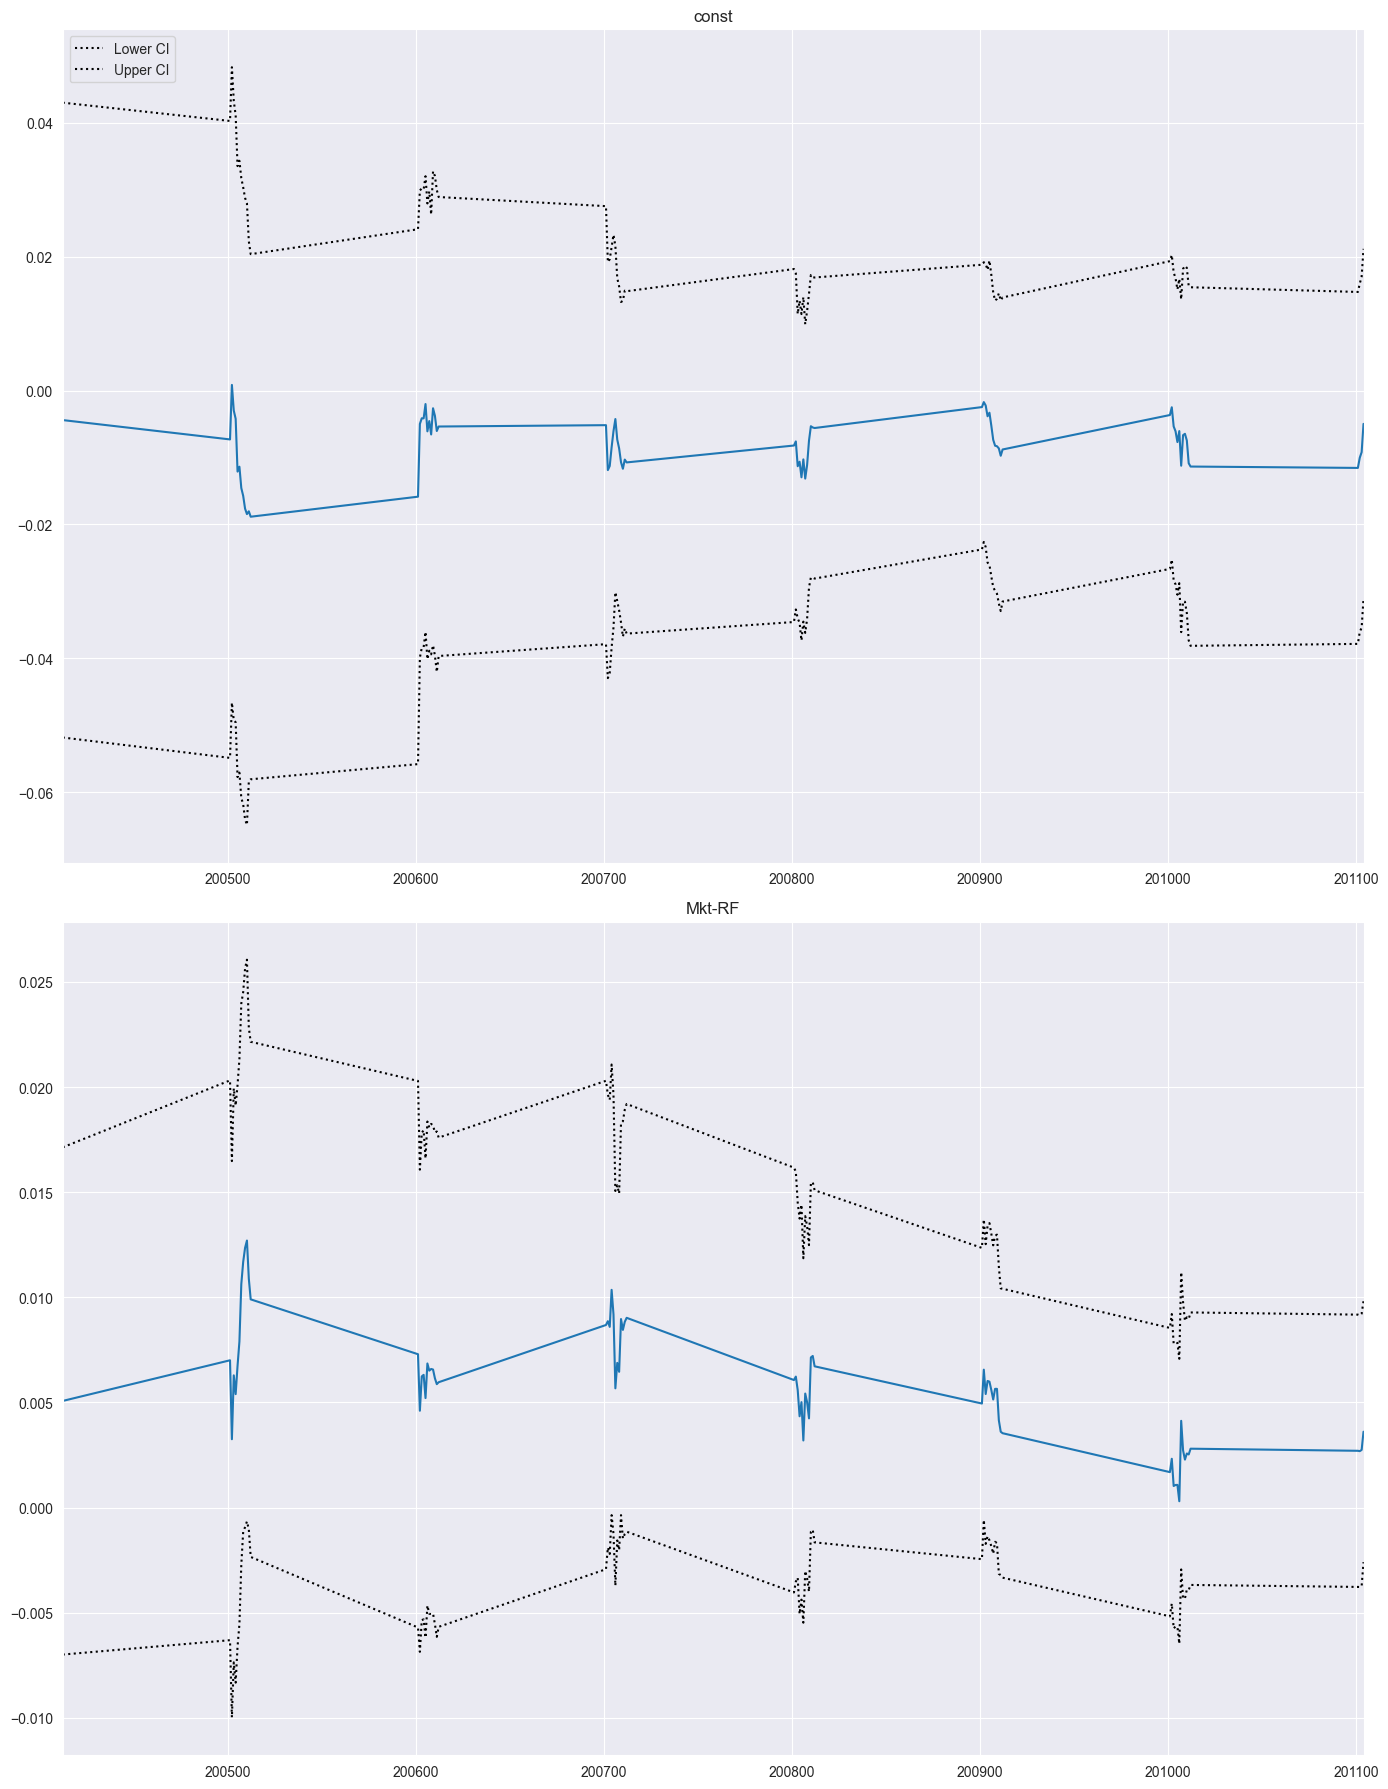

In [31]:
# time series plot and 95% CI of const and risk free market return
fig = rres.plot_recursive_coefficient(variables=['const','Mkt-RF'], figsize=(14, 18))

# 2 Fama-MacBeth Regression

In [ ]:
# data preparation


In [ ]:
# cross-sectional reg

beta = (df
        .groupby('YYYYMM')
        .apply(lambda x: smf.ols(
            formula = "CRSP['MthRet'] ~ ",
            data = x
            )
            .fit()
    )
    .reset_index()
)

In [ ]:
# time-series aggregation


In [ ]:
# visualization

# 3 LASSO Regression

# 4 Mean-Variance Portfolio